# PN2V Training
Here we will use the estimated noise model (from the notebooks ```1a_CreateNoiseModel_Calibration.ipynb``` or ```1b_CreateNoiseModel_Bootstrap.ipynb```) and train a PN2V network on single noisy images.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np

from ppn2v.unet import UNet
from ppn2v.pn2v import utils
from ppn2v.pn2v import gaussianMixtureNoiseModel
from ppn2v.pn2v import histNoiseModel
from ppn2v.pn2v import training
from tifffile import imread


# See if we can use a GPU
device=utils.getDevice()

CUDA available? True


### Load Data

Load the data that needs to be denoised. It is expected that you have downloaded the datasets and created a noise model (GMM- and  histogram- based) using the notebooks ```1a_CreateNoiseModel_Calibration.ipynb``` or ```1b_CreateNoiseModel_Bootstrap.ipynb```). Ensure that for `Mouse Actin`, the data to be denoised is named ```sample_attempt2.tif``` and not the diaphragm data. 

In [2]:
path='../../../data/Mouse actin/Mouse actin/'
# Load the training data
data=imread(path+'sample_attempt2.tif')
dataName = 'mouseactin'

Uncomment the pertinent `nameNoiseModel` to choose the noiseModel of interest

In [3]:
nameNoiseModel ='HistNoiseModel_'+dataName+'_'+'calibration'
# nameNoiseModel='GMMNoiseModel_'+dataName+'_'+str(3)+'_'+str(2)+'_'+'calibration'
# nameNoiseModel ='HistNoiseModel_'+dataName+'_'+'bootstrap'
# nameNoiseModel='GMMNoiseModel_'+dataName+'_'+str(3)+'_'+str(2)+'_'+'bootstrap'


In [4]:
namePN2VModel=nameNoiseModel
if('HistNoiseModel' in namePN2VModel):
    histogram = np.load(path+nameNoiseModel+'.npy') 
    noiseModel= histNoiseModel.NoiseModel(histogram, device=device)
elif('GMMNoiseModel' in namePN2VModel):
    params= np.load(path+nameNoiseModel+'.npz')
    noiseModel = gaussianMixtureNoiseModel.GaussianMixtureNoiseModel(params = params, device = device)
    

### Create the Network and Train it
This can take a while.

In [5]:
# Create a network with 800 output channels that are interpreted as samples from the prior.
net = UNet(800, depth=3)

# Split training and validation data.
my_train_data=data[:-5].copy()
my_val_data=data[-5:].copy()
np.random.shuffle(my_train_data)
np.random.shuffle(my_val_data)

# Start training.
trainHist, valHist = training.trainNetwork(net=net, trainData=my_train_data, valData=my_val_data,
                                           postfix=namePN2VModel, directory=path, noiseModel=noiseModel,
                                           device=device, numOfEpochs= 200, stepsPerEpoch=5, 
                                           virtualBatchSize=20, batchSize=1, learningRate=1e-3)

Epoch 0 finished      
avg. loss: 3.757097852230072+-(2SEM)0.11305159661389852      
Epoch 1 finished      
avg. loss: 3.6401143670082092+-(2SEM)0.1790737662224937      
Epoch 2 finished      
avg. loss: 3.6402241230010985+-(2SEM)0.2332181574329718      
Epoch 3 finished      
avg. loss: 3.63913437128067+-(2SEM)0.23425412904015203      
Epoch 4 finished      
avg. loss: 3.3582788705825806+-(2SEM)0.1496287469264897      
Epoch 5 finished      
avg. loss: 3.4834728121757506+-(2SEM)0.18766026306045974      
Epoch 6 finished      
avg. loss: 3.310875880718231+-(2SEM)0.13737433332871915      
Epoch 7 finished      
avg. loss: 3.2942659974098207+-(2SEM)0.13526735716069618      
Epoch 8 finished      
avg. loss: 3.471932530403137+-(2SEM)0.18722473139059828      
Epoch 9 finished      
avg. loss: 3.519174802303314+-(2SEM)0.20133243082143984      
Epoch 10 finished      
avg. loss: 3.420630168914795+-(2SEM)0.1452281143888437      
Epoch 11 finished      
avg. loss: 3.428307044506073+-(2SEM)0.16

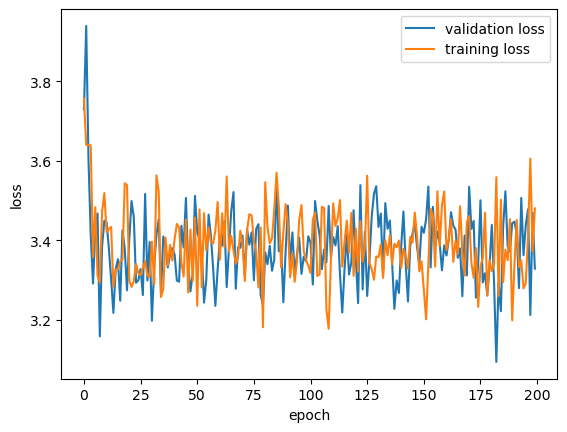

In [6]:
# Let's look at the training and validation loss
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(valHist, label='validation loss')
plt.plot(trainHist, label='training loss')
plt.legend()
plt.show()